In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import os
from glob import glob
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
# from resizeimage import resizeimage
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# images_blue, flattened_blue , X_blue = process_images(blue_dir)

In [4]:

input_dir = 'GTZAN/images_original/'

# Define input directory
def process_images(path): 
    images = []
    flattened = []
    # Loop over all images in input directory
    for filename in os.listdir(path):
        # Load image
        image_path = os.path.join(path, filename)
        image = cv2.imread(image_path)
        # print(image.shape)
        resize = cv2.resize(image, (100, 70))
        images.append(resize)
        flattened.append(np.array(resize).flatten())   
    X = np.asarray(flattened)        
    return images, flattened, X


def process_categories(input_dir):
    X_categories = []
    y_labels = []
    

    for i,subdir in enumerate(os.listdir(input_dir)):
        images, flattened, X = process_images(os.path.join(input_dir, subdir))
        X_categories.append(X)
        y_labels.append(np.full(len(X), i))
    X = np.vstack(X_categories)
    y = np.concatenate(y_labels)
    return X, y
    

X, y = process_categories(input_dir)


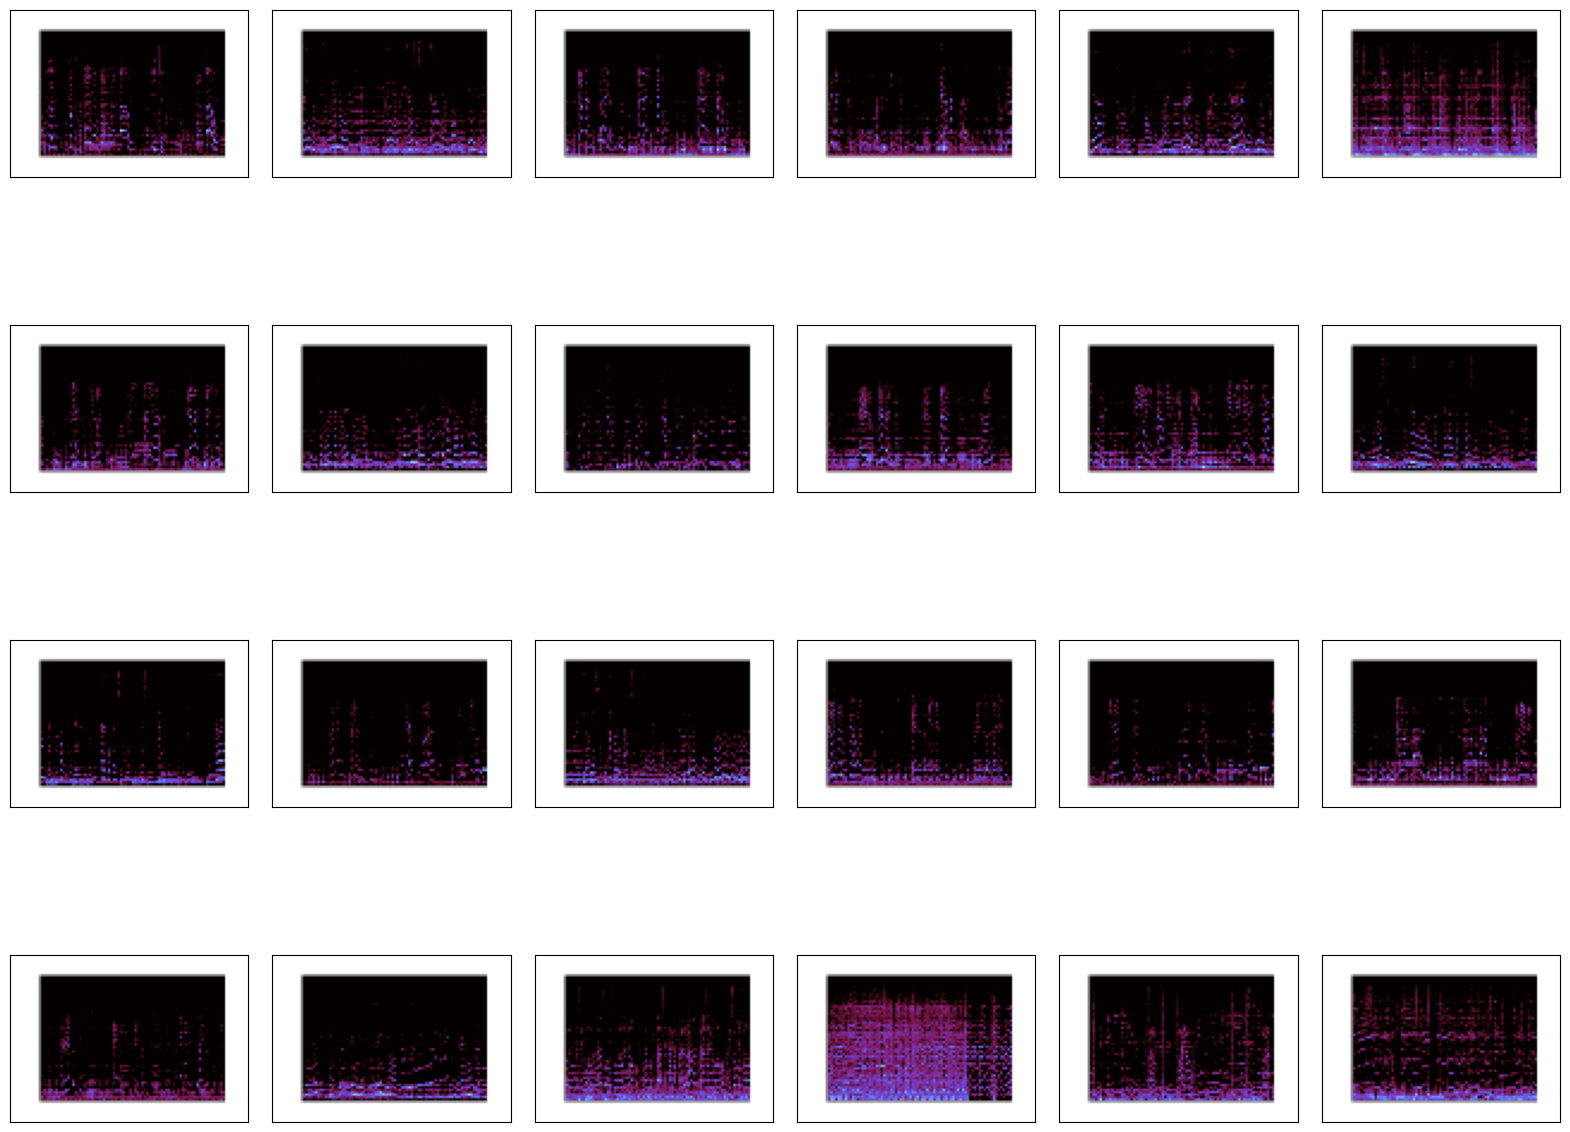

In [5]:
blue_dir = 'GTZAN/images_original/blues'
images_blue, flattened_blue , X_blue = process_images(blue_dir)

#plot the photos 
def original_photos(images):
    fig, ax = plt.subplots(4, 6, figsize=(20, 16),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

    k = 0
    for i in range(4):
        for j in range(6):
            ax[i, j].imshow(images[k])
            k += 1
            
    plt.show()
original_photos(images_blue)        

In [6]:
#train test split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.20, random_state=123)
print(f'There are {len(X_train)} training images, and {len(X_test)} testing images.' )

There are 799 training images, and 200 testing images.


## SVC: baseline analysis

In [44]:
svc = LinearSVC(verbose=0).fit(X_train, y_train)

score = svc.score(X_train, y_train)
print("Score: ", score)

#prediction
y_pred = svc.predict(X_test)

cr = classification_report(y_test, y_pred)
print(cr)

Score:  0.9987484355444305
              precision    recall  f1-score   support

           0       0.42      0.56      0.48        18
           1       0.70      0.67      0.68        24
           2       0.25      0.24      0.24        17
           3       0.53      0.32      0.40        28
           4       0.25      0.31      0.28        13
           5       0.43      0.60      0.50        15
           6       0.26      0.33      0.29        18
           7       0.33      0.25      0.29        20
           8       0.40      0.42      0.41        24
           9       0.50      0.43      0.47        23

    accuracy                           0.41       200
   macro avg       0.41      0.41      0.40       200
weighted avg       0.43      0.41      0.41       200



/Users/swimmingcircle/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## CNN

In [37]:
X_train.shape

(799, 21000)

In [38]:
import numpy as np
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 100, 70, 3))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 100, 70, 3))

# X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 432, 288, 3))
# X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 432, 288, 3))
X_train_reshaped.shape, X_test_reshaped.shape

((799, 100, 70, 3), (200, 100, 70, 3))

In [39]:
import numpy as np

# Reshape x_train to a 4D tensor
height = 100
width = 70
channels = 3

# Convert x_train to float32 data type and normalize the pixel values to [0, 1]
X_train_reshaped = X_train_reshaped.astype(np.float32) / 255.0
X_test_reshaped = X_test_reshaped.astype(np.float32) / 255.0
y_train_reshaped = y_train.reshape(-1,1)
y_test_reshaped = y_test.reshape(-1,1)

In [32]:
import tensorflow as tf

# Define input shape
input_shape = (height, width, channels)

# Define model
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 138, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 74, 69, 32)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 163392)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               20914304  
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                      

In [40]:
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train_reshaped)
y_test_one_hot = to_categorical(y_test_reshaped)

In [41]:
model.fit(X_train_reshaped, y_train_one_hot, epochs=1, validation_data=(X_test_reshaped, y_test_one_hot))

ValueError: in user code:

    File "/Users/swimmingcircle/miniforge3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/swimmingcircle/miniforge3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/swimmingcircle/miniforge3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/swimmingcircle/miniforge3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/Users/swimmingcircle/miniforge3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/swimmingcircle/miniforge3/envs/tf/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 150, 140, 3), found shape=(None, 100, 70, 3)


In [42]:
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model
input_shape = (height, width, channels)
model = build_model(input_shape)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 98, 68, 32)        896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 98, 68, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Batc  (None, 98, 68, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_14 (Conv2D)          (None, 96, 66, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 96, 66, 32)       0         
 g2D)                                                            
                                                      

In [43]:
model.fit(X_train_reshaped, y_train_one_hot, epochs=10, validation_data=(X_test_reshaped, y_test_one_hot))

Epoch 1/10


2023-04-15 21:37:48.658071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - ETA: 0s - loss: 15.4581 - accuracy: 0.0964

2023-04-15 21:37:55.506242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 8s 216ms/step - loss: 15.4581 - accuracy: 0.0964 - val_loss: 22.2063 - val_accuracy: 0.1750
Epoch 2/10
25/25 [==============================] - 4s 161ms/step - loss: 2.3026 - accuracy: 0.1064 - val_loss: 2.6133 - val_accuracy: 0.0900
Epoch 3/10
25/25 [==============================] - 4s 162ms/step - loss: 2.3026 - accuracy: 0.0939 - val_loss: 2.7646 - val_accuracy: 0.0900
Epoch 4/10
25/25 [==============================] - 4s 160ms/step - loss: 2.3025 - accuracy: 0.1064 - val_loss: 2.7399 - val_accuracy: 0.0900
Epoch 5/10
25/25 [==============================] - 4s 160ms/step - loss: 2.3024 - accuracy: 0.1064 - val_loss: 2.5786 - val_accuracy: 0.0900
Epoch 6/10
25/25 [==============================] - 4s 160ms/step - loss: 2.3031 - accuracy: 0.1064 - val_loss: 2.3865 - val_accuracy: 0.1000
Epoch 7/10
25/25 [==============================] - 4s 161ms/step - loss: 2.3109 - accuracy: 0.1064 - val_loss: 2.2900 - val_accuracy: 0.0850
Epoch 8/10
25/2